Выполнили:

Шаллиева Вера Владимировна, поток : 1.1, ИСУ: 367633

Черномор Маргарита Дмитриевна, поток 1.1, ИСУ: 369021


Была выбрана задача Классификации (Сверточная сеть)

Набор данных-["KMNIST"](https://github.com/rois-codh/kmnist)

Kuzushiji-MNIST содержит 70 000 изображений размером 28x28 в оттенках серого, охватывающих 10 классов (по одному из каждого столбца хираганы), и идеально сбалансирован, как и исходный набор данных MNIST (6000/1000 обучающих/тестирующих изображений для каждого класса).

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import torchvision as tv
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [ ]:
BATCH_SIZE=64

In [ ]:
train_dataset = tv.datasets.KMNIST(
    root='.', train=True, transform=tv.transforms.ToTensor(), download=True
)
test_dataset = tv.datasets.KMNIST(
    root='.', train=False, transform=tv.transforms.ToTensor(), download=True
)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 18.2M/18.2M [00:11<00:00, 1.58MB/s]


Extracting ./KMNIST/raw/train-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 280kB/s]


Extracting ./KMNIST/raw/train-labels-idx1-ubyte.gz to ./KMNIST/raw



100%|██████████| 3.04M/3.04M [00:01<00:00, 1.57MB/s]


Extracting ./KMNIST/raw/t10k-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 5.12k/5.12k [00:00<00:00, 5.17MB/s]

Extracting ./KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./KMNIST/raw



In [ ]:
train_dataset.classes

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

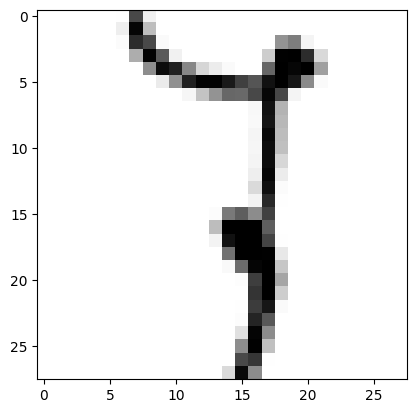

In [ ]:
plt.imshow(train_dataset[123][0].numpy().reshape(28,28), cmap='gray_r');

In [ ]:
train_dataset[123][0].numpy().shape

(1, 28, 28)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 12, 10, 10])
Layer ReLU(). X shape: torch.Size([1, 12, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 12, 5, 5])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 300])
Layer Linear(in_features=300, out_features=50, bias=True). X shape: torch.Size([1, 50])
Layer ReLU(). X shape: torch.Size([1, 50])
Layer Linear(in_features=50, out_features=10, bias=True). X shape: torch.Size([1, 10])


In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
y = model(X)
print(y.shape)

torch.Size([1, 10])


In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [ ]:
model = model.to(dev)

In [ ]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train_model(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        net.train()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr)
%time train_model(model, train, test, trainer, num_epochs)

epoch 1, loss 0.6072, train acc 0.800, test acc 0.843
epoch 2, loss 0.1918, train acc 0.941, test acc 0.880
epoch 3, loss 0.1367, train acc 0.958, test acc 0.898
epoch 4, loss 0.1075, train acc 0.967, test acc 0.909
epoch 5, loss 0.0890, train acc 0.972, test acc 0.917
epoch 6, loss 0.0774, train acc 0.976, test acc 0.918
epoch 7, loss 0.0671, train acc 0.979, test acc 0.928
epoch 8, loss 0.0585, train acc 0.982, test acc 0.927
epoch 9, loss 0.0509, train acc 0.984, test acc 0.933
epoch 10, loss 0.0461, train acc 0.986, test acc 0.930
CPU times: user 1min 23s, sys: 582 ms, total: 1min 24s
Wall time: 1min 26s


Ср: 0.14322;  Самое большое значение Loss: 0.6072

Ср:  0.9545 (95%); Самая высокая Train Accuracy: 0.986 (98%)

Ср: 0.9083 (90%);  Самая высокая Test Accuracy: 0.933 (93%)







Уже достаточно высокие показатели, но стоит посмотреть как мы может улучшить значения благодаря свёрточной сети

In [16]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=2),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=5, padding=2),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, padding=2),
    nn.MaxPool2d(2, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.BatchNorm1d(4608),
    nn.Linear(4608, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 10),
).to(dev)
lr, num_epochs = 0.0003, 10
trainer = torch.optim.Adam(model.parameters(), lr=lr)
%time train_model(model, train, test, trainer, num_epochs)

epoch 1, loss 0.2216, train acc 0.930, test acc 0.904
epoch 2, loss 0.0856, train acc 0.973, test acc 0.932
epoch 3, loss 0.0618, train acc 0.981, test acc 0.935
epoch 4, loss 0.0509, train acc 0.984, test acc 0.945
epoch 5, loss 0.0449, train acc 0.986, test acc 0.948
epoch 6, loss 0.0365, train acc 0.989, test acc 0.952
epoch 7, loss 0.0318, train acc 0.990, test acc 0.950
epoch 8, loss 0.0284, train acc 0.991, test acc 0.955
epoch 9, loss 0.0285, train acc 0.992, test acc 0.948
epoch 10, loss 0.0255, train acc 0.992, test acc 0.955
CPU times: user 1min 52s, sys: 513 ms, total: 1min 52s
Wall time: 1min 53s


Ср: 0.06155;  Самое большое значение Loss: 0.6072

Ср:  0.9808 (98%); Самая высокая Train Accuracy: 0.992 (99%)

Ср: 0.9424 (94%);  Самая высокая Test Accuracy:0.955 (95%)

Сверточной сетью удалось повысить точность с 93.3% до 95.5%, а так же увеличился средний показатель с 90.8% на 94.2%. А так же значение функции потерь уменьшается в разы быстрее

In [17]:
y_true = []
y_pred_2 = []
for X, y in test:
  X, y = X.to(dev), y.to(dev)
  y_pred_1 = model(X)
  y_true.extend(y)
  y_pred_2.extend(y_pred_1.argmax(dim=1))

In [18]:
y_true = [i.item() for i in y_true]
y_pred_2 = [i.item() for i in y_pred_2]

In [21]:
conf_mx = confusion_matrix(y_true, y_pred_2, normalize="pred")

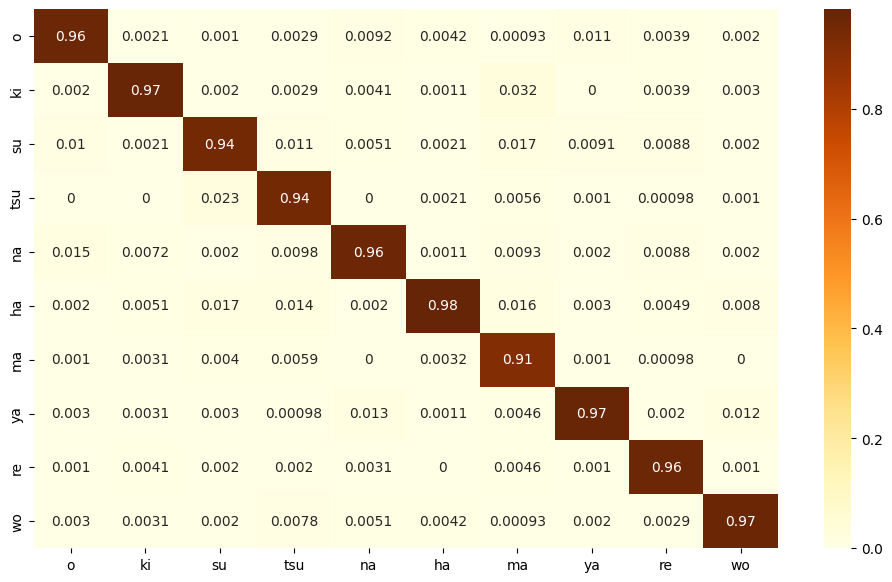

In [22]:
df_cm = pd.DataFrame(conf_mx, index=test_dataset.class_to_idx,
                     columns=test_dataset.classes)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, cmap="YlOrBr");

У иероглифов, таких как **o, ki, su, ha**, значения на диагонали высоки,модель уверенно распознает их. Показатели свыше **94%**, выбивается только **ma**, весьма путается с **ki** ; есть ещё **su**, который путается с **tsu**



#Изменения Гиперпараметров

чтобы попробовать довести модель до идеала, попробуем поменять гиперпараметры

In [37]:
BATCH_SIZE=32

На всякий случай уменьшаем нагрузку, будет обрабатывается меньше данных за один шаг

In [38]:

train_dataset = tv.datasets.KMNIST(
    root='.', train=True, transform=tv.transforms.ToTensor(), download=True
)
test_dataset = tv.datasets.KMNIST(
    root='.', train=False, transform=tv.transforms.ToTensor(), download=True
)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [39]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # Output: (32, 14, 14)

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # Output: (64, 7, 7)

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # Output: (128, 3, 3)

    nn.Flatten(),  # Преобразование в (128 * 3 * 3 = 1152)
    nn.Linear(128 * 3 * 3, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(dev)

trainer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
%time train_model(model, train, test, trainer, num_epochs)


epoch 1, loss 0.2266, train acc 0.929, test acc 0.899
epoch 2, loss 0.0821, train acc 0.975, test acc 0.937
epoch 3, loss 0.0554, train acc 0.983, test acc 0.951
epoch 4, loss 0.0444, train acc 0.986, test acc 0.950
epoch 5, loss 0.0353, train acc 0.989, test acc 0.950
epoch 6, loss 0.0283, train acc 0.991, test acc 0.960
epoch 7, loss 0.0270, train acc 0.992, test acc 0.960
epoch 8, loss 0.0219, train acc 0.994, test acc 0.953
epoch 9, loss 0.0202, train acc 0.994, test acc 0.956
epoch 10, loss 0.0190, train acc 0.994, test acc 0.960
CPU times: user 2min 20s, sys: 779 ms, total: 2min 21s
Wall time: 2min 26s


Изменения:


1.   Количество фильтров увеличивается от 32 до 128
2.   Полносвязные слои с 256 и 128 нейронами
3.   Используется Dropout(0.4)
4.   Оптимизатор Adam с learning rate 0.001



Мы смогли поднять test acc с 95.5% до 96%. Изменения совсем незначительные, но они есть. Прошлые гиперпараметры были подходящими, но нынешняя фокусируется на простоте, с меньшим количеством параметров и стандартными свёрточными ядрами, но выдаёт не менее хороший результат